In [19]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

## Import the libraries and dataset

In [48]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.model_selection import train_test_split

# Load cleaned data
df = pd.read_csv("insurance_cleaned.csv")


In [50]:
df.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital_gains', 'capital_loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'policy_bind_year',
       'policy_bind_month', 'incident_year', 'incident_month'],
      dtype='object')

## select relevant columsn

In [53]:
df_model = df[[
    'months_as_customer', 'age', 'policy_state', 'policy_csl', 'policy_deductable',
    'policy_annual_premium', 'umbrella_limit', 'insured_sex', 'insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital_gains',
    'capital_loss', 'incident_type', 'collision_type', 'incident_severity',
    'authorities_contacted', 'incident_state', 'number_of_vehicles_involved',
    'property_damage', 'bodily_injuries', 'witnesses', 'police_report_available',
    'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim',
    'auto_make', 'auto_model', 'auto_year'
]]
y = df["fraud_reported"].map({"Y": 1, "N": 0})  # Encode target

## Get dummy data

In [56]:
df_dum = pd.get_dummies(df_model)

In [58]:
df_dum.columns

Index(['months_as_customer', 'age', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'capital_gains',
       'capital_loss', 'number_of_vehicles_involved', 'bodily_injuries',
       'witnesses',
       ...
       'auto_model_Pathfinder', 'auto_model_RAM', 'auto_model_RSX',
       'auto_model_Silverado', 'auto_model_TL', 'auto_model_Tahoe',
       'auto_model_Ultima', 'auto_model_Wrangler', 'auto_model_X5',
       'auto_model_X6'],
      dtype='object', length=153)

## Train-test split

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Identify categorical & numerical columns
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(include=["int64","float64"]).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.88      0.89      0.88       151
           1       0.65      0.63      0.64        49

    accuracy                           0.82       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.82      0.82      0.82       200

ROC-AUC: 0.8228138937694284


In [4]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))
])

rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print(classification_report(y_test, rf_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

           0       0.76      0.96      0.85       151
           1       0.40      0.08      0.14        49

    accuracy                           0.74       200
   macro avg       0.58      0.52      0.49       200
weighted avg       0.67      0.74      0.68       200

ROC-AUC: 0.8520070279767537


C:\Users\gillg\anaconda3\envs\UL\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


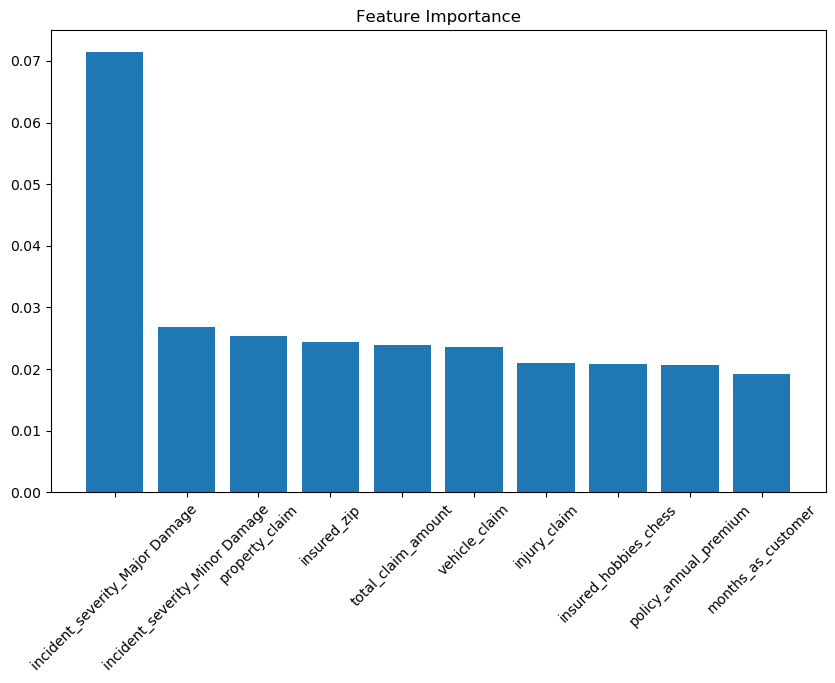

In [5]:
# After fitting RandomForest
import matplotlib.pyplot as plt
import numpy as np

feature_names = (
    list(num_cols) + 
    list(rf_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names(cat_cols))
)

importances = rf_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(10), importances[indices][:10], align="center")
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.show()



In [6]:
pip install imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# SMOTE + Random Forest pipeline
rf_smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=42
    ))
])

# Train model
rf_smote_pipeline.fit(X_train, y_train)

# Predictions
rf_smote_pred = rf_smote_pipeline.predict(X_test)

# Evaluation
print("Random Forest with SMOTE")
print(classification_report(y_test, rf_smote_pred))
print("ROC-AUC:", roc_auc_score(y_test, rf_smote_pipeline.predict_proba(X_test)[:, 1]))


SyntaxError: invalid syntax (_metadata_requests.py, line 1512)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(rf_model, param_grid_rf, scoring='roc_auc', cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)
print("Best RF AUC:", grid_rf.best_score_)
